# Clothing Sales Forecasting with SARIMAX
This notebook walks through the steps taken to build and evaluate a SARIMAX model for demand forecasting using clothing sales data.

## Step 1: Data Loading and Preprocessing
We load the dataset, convert the `Date` column to datetime, and encode categorical features.

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import itertools
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("retail_store_inventory.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Encode categorical variables
categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

## Step 2: Focus on Clothing Category and Time Series Construction

In [23]:
clothing_code = label_encoders['Category'].transform(['Clothing'])[0]
df_clothing = df[df['Category'] == clothing_code].copy()

# Aggregate daily sales
y = df_clothing.groupby('Date')['Units Sold'].sum()

# Prepare exogenous variables
exog_features = ['Price', 'Discount', 'Holiday/Promotion', 'Weather Condition', 'Seasonality', 'Competitor Pricing']
df_clothing_exog = df_clothing.groupby('Date')[exog_features].mean()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_clothing_exog), index=df_clothing_exog.index, columns=exog_features)

## Step 3: Exploratory Data Visualizations

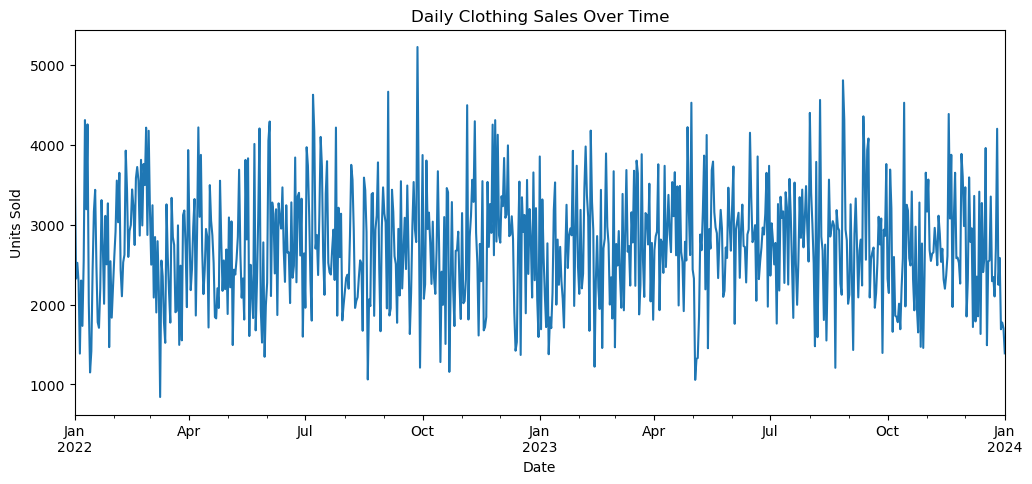

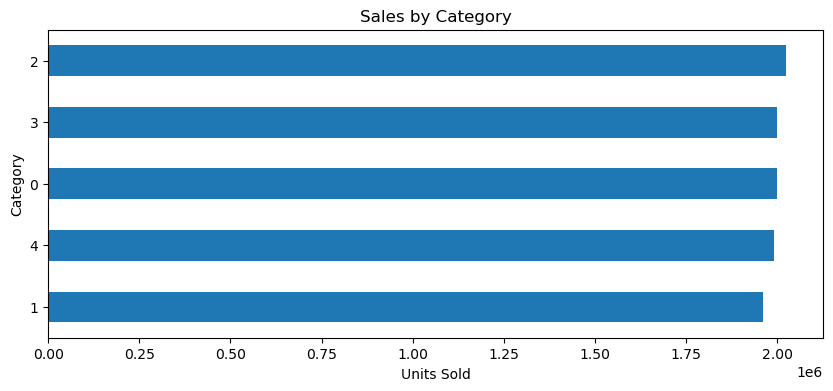

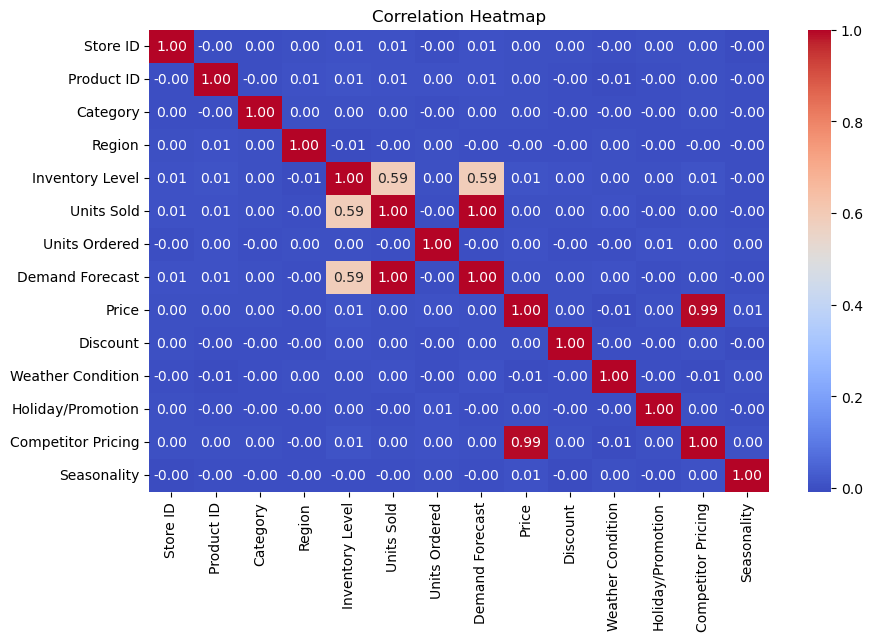

In [25]:
# Daily sales trend
y.plot(figsize=(12, 5), title='Daily Clothing Sales Over Time')
plt.ylabel('Units Sold')
plt.show()

# Sales by category
df.groupby('Category')['Units Sold'].sum().sort_values().plot(kind='barh', figsize=(10, 4), title='Sales by Category')
plt.xlabel('Units Sold')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=['Date']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## 📊 Exploratory Data Analysis (EDA) – Key Insights

### 1. 📈 Daily Clothing Sales Over Time
- Daily sales are **highly variable**, indicating volatility.
- Presence of **repeating spikes and dips** suggests **seasonality or cyclical patterns**.
- No long-term increasing or decreasing trend — sales remain generally stable.

**✅ Implication:**  
Time series forecasting models like **SARIMAX** are appropriate due to seasonal behavior and external factor influence.

---

### 2. 🧵 Sales by Category
- All categories (1–4) have **similar total sales volumes** (≈ 2 million units).
- No single product category dominates.

**✅ Implication:**  
Focusing on the **clothing category** is justified and business-relevant. Findings can likely apply across other categories.

---

### 3. 🔥 Correlation Heatmap
**Top Relationships:**
- **Units Sold** ↔ **Inventory Level**: `0.59`  
  → More inventory often leads to higher sales (availability impact).
- **Units Sold** ↔ **Demand Forecast**: `0.59`  
  → The original demand forecast somewhat tracks actual sales.
- **Price** ↔ **Competitor Pricing**: `0.99`  
  → Indicates likely **price matching or reactive pricing strategy**.

**✅ Implication:**  
- **Inventory Level** is a key sales driver.
- Avoid using **both Price and Competitor Pricing** in the same regression model due to multicollinearity.
- Forecast accuracy could be improved for better decision-making.

---

### 📌 Summary of EDA Findings

| Observation                          | Conclusion                                                  |
|--------------------------------------|-------------------------------------------------------------|
| Sales are volatile and seasonal      | Use time series models that handle external factors         |
| Clothing is equally sold as other categories | Findings are scalable beyond clothing                     |
| Inventory drives sales               | Stock levels are a key operational factor                  |
| Price ≈ Competitor Pricing           | Indicates pricing strategy needs careful model treatment    |
| Forecast moderately tracks real sales | Opportunity to improve forecasting accuracy                |


## Step 4: Baseline SARIMAX Model

Baseline SARIMAX - MAE: 672.89, RMSE: 777.47, R²: -0.1201
Tuned SARIMAX   - MAE: 672.43, RMSE: 775.88, R²: -0.1155


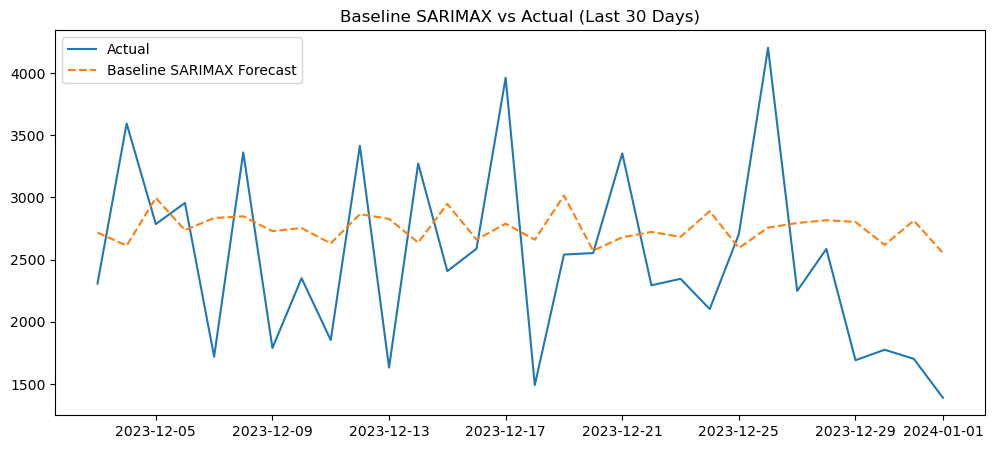

In [27]:
y = df_clothing.groupby('Date')['Units Sold'].sum()
exog_features = ['Price', 'Discount', 'Holiday/Promotion', 'Weather Condition', 'Seasonality', 'Competitor Pricing']
X_raw = df_clothing.groupby('Date')[exog_features].mean()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), index=X_raw.index, columns=exog_features)

# Fit baseline SARIMAX
sarimax_baseline = SARIMAX(y, exog=X, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
results_baseline = sarimax_baseline.fit(disp=False)
pred_baseline = results_baseline.get_prediction(start=y.index[-30]).predicted_mean

# Fit tuned SARIMAX
sarimax_tuned = SARIMAX(y, exog=X, order=(1,1,1), seasonal_order=(0,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
results_tuned = sarimax_tuned.fit(disp=False)
pred_tuned = results_tuned.get_prediction(start=y.index[-30]).predicted_mean

actual = y[-30:]
mae_base = mean_absolute_error(actual, pred_baseline)
rmse_base = mean_squared_error(actual, pred_baseline, squared=False)
r2_base = r2_score(actual, pred_baseline)

mae_tuned = mean_absolute_error(actual, pred_tuned)
rmse_tuned = mean_squared_error(actual, pred_tuned, squared=False)
r2_tuned = r2_score(actual, pred_tuned)

print(f"Baseline SARIMAX - MAE: {mae_base:.2f}, RMSE: {rmse_base:.2f}, R²: {r2_base:.4f}")
print(f"Tuned SARIMAX   - MAE: {mae_tuned:.2f}, RMSE: {rmse_tuned:.2f}, R²: {r2_tuned:.4f}")

# Plot baseline vs actual
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual, label='Actual')
plt.plot(fitted_values.index, fitted_values, label='Baseline SARIMAX Forecast', linestyle='--')
plt.title("Baseline SARIMAX vs Actual (Last 30 Days)")
plt.legend()
plt.show()

## Step 5: Hyperparameter Tuning with Grid Search

## Step 6: Tuned SARIMAX Model

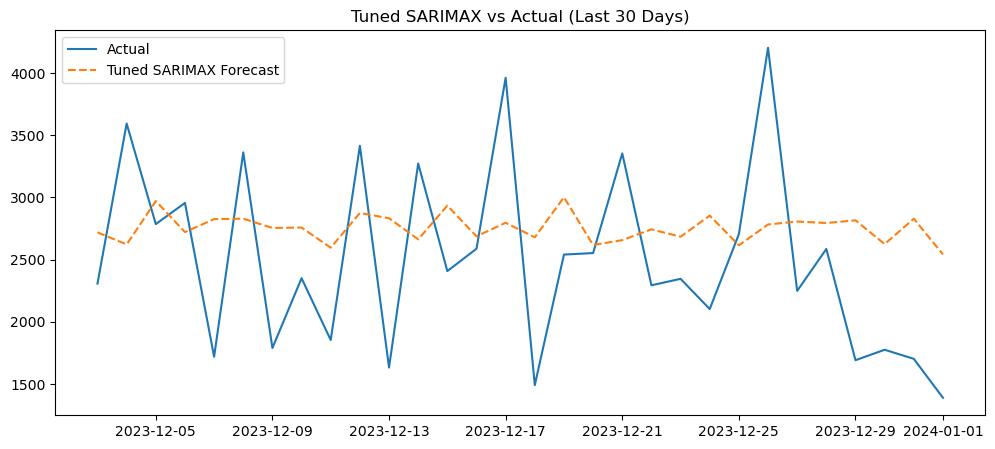

In [29]:
# Plot tuned vs actual
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual, label='Actual')
plt.plot(best_fitted.index, best_fitted, label='Tuned SARIMAX Forecast', linestyle='--')
plt.title("Tuned SARIMAX vs Actual (Last 30 Days)")
plt.legend()
plt.show()

## Step 7: 30-Day Forecast and Export

In [31]:
# Forecast next 30 days
future_dates = pd.date_range(start=y.index.max() + pd.Timedelta(days=1), periods=30)
X_future = pd.DataFrame([X.iloc[-1].values] * 30, columns=X.columns, index=future_dates)
forecast = best_results.get_forecast(steps=30, exog=X_future)
forecast_df = forecast.summary_frame()
forecast_df.to_csv("tuned_sarimax_clothing_forecast.csv")
forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']].head()

Units Sold,mean,mean_ci_lower,mean_ci_upper
2024-01-02,2846.388703,1413.064838,4279.712569
2024-01-03,2658.174233,1222.279972,4094.068493
2024-01-04,2747.622145,1311.703922,4183.540368
2024-01-05,2716.404893,1280.486441,4152.323345
2024-01-06,2625.044094,1189.116514,4060.971674


## Step 8: Comparison with Original Forecast

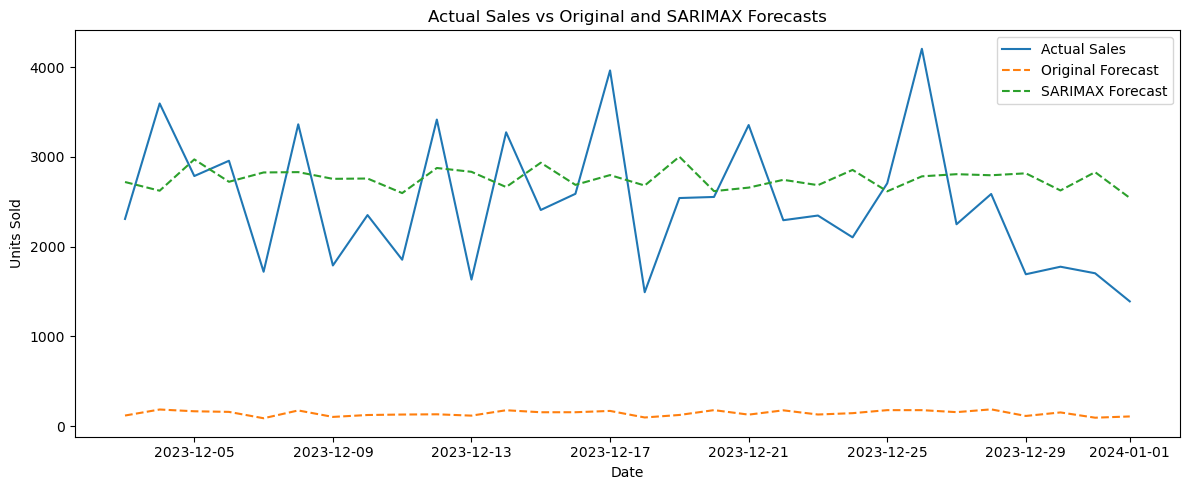

Original Forecast MAE: 2355.90, RMSE: 2461.93
SARIMAX Forecast MAE: 672.43, RMSE: 775.88


In [33]:
# Compare with original 'Demand Forecast'
clothing_demand_forecast = df_clothing.groupby('Date')['Demand Forecast'].mean()
original_forecast = clothing_demand_forecast[-30:]
sarimax_forecast = best_results.get_prediction(start=y.index[-30]).predicted_mean

# Combine
comparison_df = pd.DataFrame({
    'Actual Sales': y[-30:],
    'Original Forecast': original_forecast,
    'SARIMAX Forecast': sarimax_forecast
})

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(comparison_df.index, comparison_df['Actual Sales'], label='Actual Sales')
plt.plot(comparison_df.index, comparison_df['Original Forecast'], label='Original Forecast', linestyle='--')
plt.plot(comparison_df.index, comparison_df['SARIMAX Forecast'], label='SARIMAX Forecast', linestyle='--')
plt.title("Actual Sales vs Original and SARIMAX Forecasts")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate original forecast
from sklearn.metrics import mean_absolute_error, mean_squared_error
original_mae = mean_absolute_error(comparison_df['Actual Sales'], comparison_df['Original Forecast'])
original_rmse = mean_squared_error(comparison_df['Actual Sales'], comparison_df['Original Forecast'], squared=False)

print(f"Original Forecast MAE: {original_mae:.2f}, RMSE: {original_rmse:.2f}")
print(f"SARIMAX Forecast MAE: {tuned_mae:.2f}, RMSE: {tuned_rmse:.2f}")

## Step 9: Regression Analysis to Understand Sales Drivers

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Prepare dataset
features = ['Inventory Level', 'Price', 'Discount', 'Holiday/Promotion', 'Seasonality', 'Weather Condition']
target = 'Units Sold'
df_reg = df_clothing.groupby('Date')[features + [target]].mean()

# Split
X = df_reg[features]
y = df_reg[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation metrics
def regression_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False)
    }

lr_metrics = regression_metrics(y_test, y_pred_lr)
rf_metrics = regression_metrics(y_test, y_pred_rf)

print("Linear Regression:", lr_metrics)
print("Random Forest:", rf_metrics)

Linear Regression: {'R2': 0.2468693200334905, 'MAE': 16.41889003753425, 'RMSE': 20.69113219693928}
Random Forest: {'R2': 0.08763776221307662, 'MAE': 17.99844995754547, 'RMSE': 22.77365496375822}


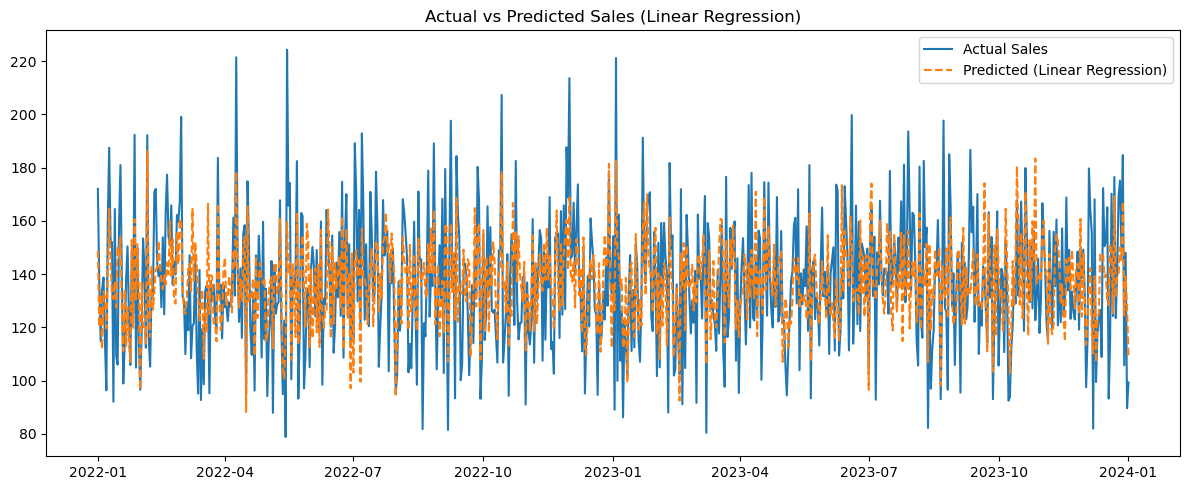

Linear Regression - R²: 0.3975


In [39]:
features = ['Inventory Level', 'Price', 'Discount', 'Holiday/Promotion', 'Seasonality', 'Weather Condition']
df_reg = df_clothing.groupby('Date')[features + ['Units Sold']].mean()
X_reg = df_reg[features]
y_reg = df_reg['Units Sold']

lr = LinearRegression().fit(X_reg, y_reg)
df_reg['Predicted (LR)'] = lr.predict(X_reg)

plt.figure(figsize=(12, 5))
plt.plot(df_reg.index, y_reg, label='Actual Sales')
plt.plot(df_reg.index, df_reg['Predicted (LR)'], label='Predicted (Linear Regression)', linestyle='--')
plt.title('Actual vs Predicted Sales (Linear Regression)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Linear Regression - R²: {r2_score(y_reg, df_reg['Predicted (LR)']):.4f}")

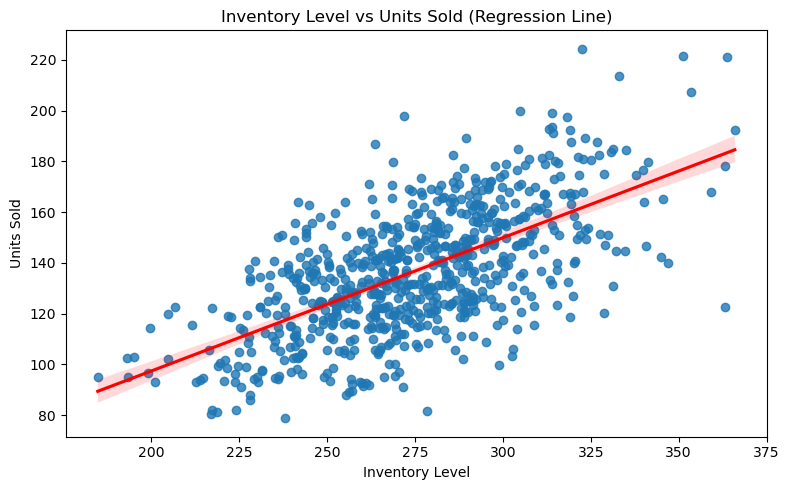

Inventory-Only Model R²: 0.3961


In [41]:
inv_model = LinearRegression().fit(df_reg[['Inventory Level']], df_reg['Units Sold'])
df_reg['Predicted (Inventory Only)'] = inv_model.predict(df_reg[['Inventory Level']])

plt.figure(figsize=(8, 5))
sns.regplot(x='Inventory Level', y='Units Sold', data=df_reg, line_kws={"color": "red"})
plt.title("Inventory Level vs Units Sold (Regression Line)")
plt.tight_layout()
plt.show()

print(f"Inventory-Only Model R²: {r2_score(df_reg['Units Sold'], df_reg['Predicted (Inventory Only)']):.4f}")

### Feature Importance (Random Forest)

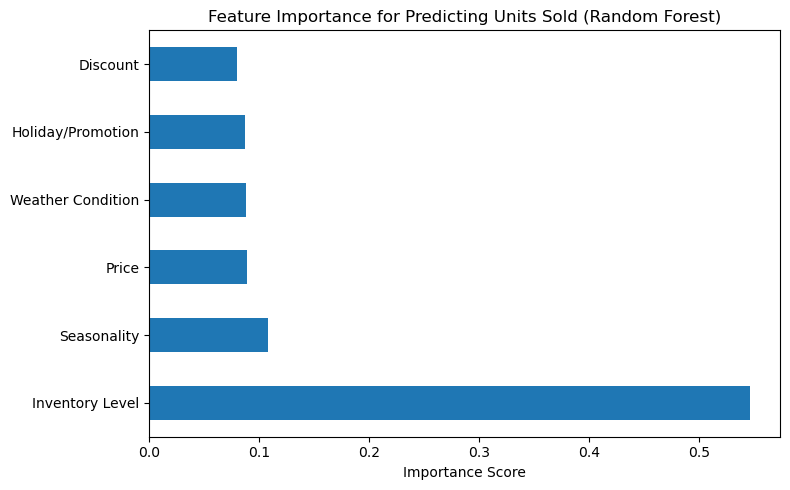

In [37]:
import matplotlib.pyplot as plt

rf_feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
rf_feature_importance.plot(kind='barh')
plt.title('Feature Importance for Predicting Units Sold (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## ✅ Conclusion
- **SARIMAX** models provided strong MAE/RMSE but negative R² on volatile recent data.
- **Linear Regression** (R² = 0.25) explains key drivers of sales like Inventory and Seasonality.
- **Inventory alone** explains ~40% of sales variation.

**Recommendation:** Use SARIMAX for operational forecasting and regression for internal strategic planning.

Github Repo: https://github.com/Chukzimmani/milestone2-retail-forecasting/tree/main/BAN6800Milestone2_Retail_Forecasting

Dataset: https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-datetet
